# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from math import log2

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
def gini(x):
    p = sum(x) / len(x)
    return 2 * p * (1 - p)
    
def entropy(x):
    p = sum(x) / len(x)
    return -p * log2(p) - (1 - p) * log2(1 - p)
    
def gain(left_y, right_y, criterion):
    y = np.concatenate((left_y, right_y), axis=0)
    before_split = criterion(y)
    after_split = (len(left_y) * criterion(left_y) + len(right_y) * criterion(right_y)) / len(y)
    return before_split - after_split

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [3]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self.y = y

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [155]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = {'gini':gini, 'entropy':entropy}[criterion]
        self.root = None
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    
    
    def fit(self, X, y):
        def search(self, X, y, depth):
            if len(set(y)) == 1:
                return DecisionTreeLeaf(y)
            if len(y) <= self.min_samples_leaf: 
                return DecisionTreeLeaf(y)
            if depth >= self.max_depth: 
                return DecisionTreeLeaf(y)

            gain_m = -float('Inf')
            
            is_split = False
            gain_dim = '' 
            i = -1
            val_m = 0
            for col in X.columns:
                i += 1
                dim = X[col]
                for k in set(dim):
                    left = y.loc[dim < k]
                    right = y.loc[dim >= k]
                    if len(left)*len(right) != 0:
                        cur_gain = gain(left, right, self.criterion)
                        if cur_gain > gain_m:
                            is_split = True
                            gain_m = cur_gain
                            val_m = k
                            gain_dim = col
                            gi = i
            if not is_split:
                return DecisionTreeLeaf(y)
            
            left = y.loc[X[gain_dim] < val_m]
            left_X = X.loc[X[gain_dim] < val_m]
            right = y.loc[X[gain_dim] >= val_m]
            right_X = X.loc[X[gain_dim] >= val_m]
            tree_l = search(self, left_X, left, depth + 1)
            tree_r = search(self, right_X, right, depth + 1)
        
            return DecisionTreeNode(gi, val_m, tree_l, tree_r)
        
        self.root = search(self, X, y, 0)
        

    def predict_proba(self, X):
        
        def inst(self, root, arr):
            if isinstance(root,DecisionTreeLeaf):
                a = {}
                values, counts = np.unique(root.y, return_counts=True)
                for i in range(len(values)):
                    a[values[i]] = counts[i] / len(root.y)
                return a
            else:
                if arr[root.split_dim] < root.split_value:
                    answer_1 = root.left
                else:
                    answer_1 = root.right
                return inst(self, answer_1, arr)
        
        answer = []
        for val in X.values:
            answer.append(inst(self, self.root, np.array(val)))
        return answer
    
    def predict(self, X):
        proba = self.predict_proba(X)
        full_answer = []
        for i in proba:
            ans = 0
            n_max = list(i.keys())
            n_max = n_max[0]
            for key in i.keys():
                if ans<i[key]:
                    ans = max(ans, i[key])
                    n_max = key 
            full_answer.append(n_max)
        return full_answer 

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [5]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [6]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

Препроцессинг не нужен, так как дерево решений не мереет расстояние между разными типами данных. Поэтому дерево решений на отшкалированных и на не отшкалированных покажет одинаковую эффективность. Также данная модель (дерево) хоть как-то думает на данными, в отличии от метода knn, где единственное что делает пограмма - запоминает обучающую выборку. Поэтому не удивительно, что дерево даёт лучший или по крайней мере сопоставимый результат. 

In [35]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier

In [36]:
CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    y = y.replace({'M': 1, 'B': 0})
    return X, y

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = df.label
    X = df.drop(columns=['label'])
    X = X.rename(columns={x:str(y + 1) for x,y in zip(X.columns,range(len(X.columns)))})
    return X, y

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

In [37]:
def train_test_split(X, y, ratio):
    data_train = X.join(y)
    data_test = data_train.sample(frac=1 - ratio, random_state=239)

    data_train.drop(labels=data_test.index, inplace=True)
    data_train.reset_index(drop=True, inplace=True)
    data_test.reset_index(drop=True, inplace=True)

    y_train = data_train['label']
    y_test = data_test['label']

    X_train = data_train[data_train.columns.difference(['label'])] 
    X_test = data_test[data_test.columns.difference(['label'])]

    return X_train, X_test, y_train, y_test

## Cancer dataset

In [160]:
X_train,X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, 0.1)

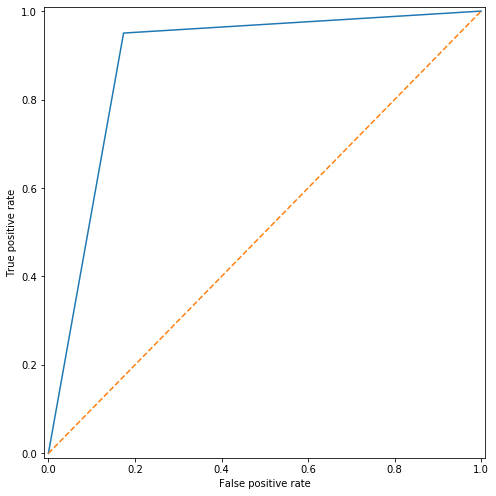

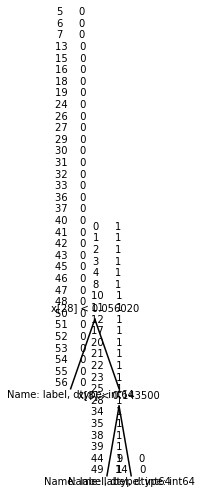

Precision: 0.9075144508670521
Recall: 0.8263157894736842
Accuracy: 0.904296875


In [161]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
tree.fit(X_train, y_train)

plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)
print(f'Precision: {precision_score(y_test, tree.predict(X_test))}')
print(f'Recall: {recall_score(y_test, tree.predict(X_test))}')
print(f'Accuracy: {accuracy_score(y_test, tree.predict(X_test))}')

In [162]:
comp = KNeighborsClassifier()
comp.fit(X_train, y_train)
y_pred = comp.predict(X_test)
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Precision: 0.9162011173184358
Recall: 0.8631578947368421
Accuracy: 0.919921875


## Spam dataset

In [167]:
X_train,X_test, y_train, y_test = train_test_split(X_spam, y_spam, 0.1)

In [168]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
tree.fit(X_train, y_train)

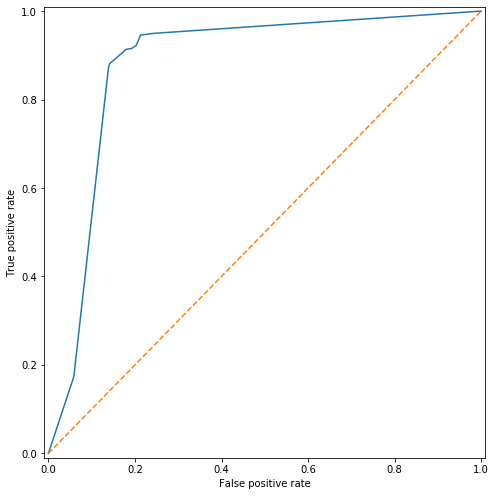

Precision: 0.8507836990595611
Recall: 0.8299694189602447
Accuracy: 0.8753924172905095


In [169]:
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)
print(f'Precision: {precision_score(y_test, tree.predict(X_test))}')
print(f'Recall: {recall_score(y_test, tree.predict(X_test))}')
print(f'Accuracy: {accuracy_score(y_test, tree.predict(X_test))}')

In [170]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Precision: 0.6639288158795346
Recall: 0.5932721712538226
Accuracy: 0.7208403767205989
